## In this notebook, we try to get the thermodynamic factors of the LiPF6 in EC:EMC system based on the paper:
#### Self, J.; Bergstrom, H. K. Hypoeutectic Liquid-Solid Phase Diagrams for Ternary Lithium-Ion Battery Electrolytes. Journal of Physical Chemistry Letters 2024, 15 (2), 416-421, Article. DOI: 10.1021/acs.jpclett.3c03169.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl; 
import sympy as sy; from sympy import symbols,diff
fs=17; 
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)


In [2]:
###### NOTE: m here refer to the molality of salt   ##############
def Activity_Sol_Bin_i_m_sy(m,m_bar_i,para_i_salt): 
    """ Eq. (2) in Self 2024 paper, 
    For solvent only, in binary electrolyte system """
    # Unpack parameter:
    [c_i_salt,d_i_salt,e_i_salt,f_i_salt] = para_i_salt
    first_term = 1 - 2*m  /  ( 1/m_bar_i + 2*m )
    power = (
        c_i_salt*m**1.5 + d_i_salt*m**2.0 + 
        e_i_salt*m**2.5 + f_i_salt*m**3.0 )
    a_i_m = first_term * sy.exp(power)    # use sy
    return a_i_m

def Activity_Sol_Bin_i_Xj_sy(X_j,para_i_j): 
    """ Eq. (3) in Self 2024 paper, 
    For solvent only, in binary solvent system """
    # Unpack parameter:
    [c_i_j,d_i_j,e_i_j] = para_i_j
    first_term = 1 - X_j
    power = (
        c_i_j*X_j**2.0 + d_i_j*X_j**3.0 + 
        e_i_j*X_j**4.0  )
    a_i_Xj = first_term * sy.exp(power)
    return a_i_Xj

def Activity_Sol_Ter_i_sy(X_i,X_j,m,m_bar_i,Para): 
    """ Eq. (7) in Self 2024 paper, 
    For solvent only, in ternary system (2 solvent 1 salt) """
    # Unpack parameter:
    para_i_salt,para_i_j,para_i_j_salt = Para
    [c_i_j_salt,d_i_j_salt,e_i_j_salt] = para_i_j_salt

    X_j_apo =  X_j / (X_i+X_j)  # apo short for apostrophe
    a_i_Xjapo = Activity_Sol_Bin_i_Xj_sy(X_j,para_i_j)
    # a_i_Xjapo = Activity_Sol_Bin_i_Xj_sy(X_j,para_i_j)
    a_i_m  = Activity_Sol_Bin_i_m_sy(m,m_bar_i,para_i_salt)
    first_term = (
        X_i * 
        a_i_Xjapo / (1-X_j_apo) * 
        a_i_m  / (1 - 2*m  /  ( 1/m_bar_i + 2*m ))       )
    power = (
        c_i_j_salt*m**1.5*X_j_apo**2.0 + 
        d_i_j_salt*m**1.5*X_j_apo**3.0 + 
        e_i_j_salt*m**2.0*X_j_apo**2.0  )
    a_i_Xj_m = first_term * sy.exp(power)
    return a_i_Xj_m

#### To test whether we type the equations correctly, we try to implement Eq. (10) in Self 2024 paper, and compare the results with Fig. 3 

In [3]:
# The molar mass comes from paper: Jung, T.; Wang, A. A.; Monroe, C. W. Overpotential from Cosolvent Imbalance in Battery Electrolytes: LiPF(6) in EMC:EC. ACS Omega 2023, 8 (23), 21133-21144. DOI: 10.1021/acsomega.3c02088.
m_bar_EC = 88.062*1e-3 #   kg/mol
m_bar_EMC= 104.105*1e-3 #   kg/mol
m_bar_e  = 151.905*1e-3 #   kg/mol
# assume 1 kg EC and EMC, 
n_EC  = 0.5 / m_bar_EC   # unit: mol
n_EMC = 0.5 / m_bar_EMC    # unit: mol
m_EC  = n_EC/ 1          # unit: mol/kg
m_EMC = n_EMC/ 1         # unit: mol/kg
print(f"When mass ratio is 1:1, mole ratio of EC and EMC are: {n_EC/n_EMC:.4f}, roughly equal to 1.2")
print(f"Molalities are: m_EC={m_EC:.4f}, m_EMC={m_EMC:.4f} mol/kg")

When mass ratio is 1:1, mole ratio of EC and EMC are: 1.1822, roughly equal to 1.2
Molalities are: m_EC=5.6778, m_EMC=4.8028 mol/kg


In [4]:
# reproduce eq. (10)
def Fun_Intergral_sy(m,m_EC,m_EMC,m_bar_EC,m_bar_EMC,Para_EC,Para_EMC):
    """ Eq. (10) """
    X_EC  = m_EC  / (m_EC+m_EMC+2*m)
    X_EMC = m_EMC / (m_EC+m_EMC+2*m)

    # i=EMC, j=EC
    a_EMC_XEMC_m = Activity_Sol_Ter_i_sy(X_EMC,X_EMC,m,m_bar_EMC,Para_EMC)
    [para_EMC_salt,para_EMC_EC,para_EMC_EC_salt] = Para_EMC
    a_EMC_XEMC   = Activity_Sol_Bin_i_Xj_sy(X_EMC,para_EMC_EC)
    first_term = m_EMC * sy.log(a_EMC_XEMC_m / a_EMC_XEMC)

    # i=EC, j=EMC
    a_EC_XEMC_m = Activity_Sol_Ter_i_sy(X_EC,X_EMC,m,m_bar_EC,Para_EC)
    [para_EC_salt,para_EC_EMC,para_EC_EMC_salt] = Para_EC
    a_EC_XEMC   = Activity_Sol_Bin_i_Xj_sy(X_EMC,para_EC_EMC)
    second_term  = m_EC * sy.log(a_EC_XEMC_m / a_EC_XEMC)

    Intergral = first_term + second_term
    return Intergral

# instead of using Eq. (10), directly use Eq. (8)
def Fun_TDF_sy(m,m_EC,m_EMC,m_bar_EC,m_bar_EMC,Para_EC,Para_EMC):
    """ Eq. (8) """
    x=symbols("x",real=True)
    X_EC  = m_EC  / (m_EC+m_EMC+2*m)
    X_EMC = m_EMC / (m_EC+m_EMC+2*m)

    # i=EC, j=EMC
    a_EC_XEMC_m = Activity_Sol_Ter_i_sy(X_EC,X_EMC,m,m_bar_EC,Para_EC)
    first_term   = 0.5/m**2 * m_EC * diff(sy.log(a_EC_XEMC_m),m)
    # i=EMC, j=EC
    a_EMC_XEC_m = Activity_Sol_Ter_i_sy(X_EMC,X_EC,x,m_bar_EMC,Para_EMC)
    second_term = 0.5/m**2 * m_EMC * diff(sy.log(a_EMC_XEC_m),m)

    TDF = first_term + second_term
    return TDF


In [5]:
# Define input - from Table 2 and 3 in Self 2024 paper
para_EC_salt = [0.042895, -0.38832, 0.0663, -0.017291]
para_EC_EMC  = [-0.66992, 4.2840,   -2.5671]
para_EC_EMC_salt = [2.7936, -7.8747, 1.7636]
para_EMC_salt = [0.82629, -1.7913, 1.7011, -0.63441]
para_EMC_EC  = [0.62190, 2.5617,   -2.5672]
para_EMC_EC_salt = para_EC_EMC_salt
Para_EC  = [para_EC_salt,para_EC_EMC,para_EC_EMC_salt]
Para_EMC = [para_EMC_salt,para_EMC_EC,para_EMC_EC_salt]

x=symbols("x",real=True)
TDF_Salt = -0.5* diff(Fun_Intergral_sy(x,m_EC,m_EMC,m_bar_EC,m_bar_EMC,Para_EC,Para_EMC),x)
TDF_Salt2 = Fun_TDF_sy(x,m_EC,m_EMC,m_bar_EC,m_bar_EMC,Para_EC,Para_EMC)
TDF_Salt_List = []
TDF_Salt_List2 = []
m_e_List =  np.linspace(0.0,0.95,40).tolist()
for m_e in m_e_List:
    TDF_Salt_List.append(TDF_Salt.subs({x:m_e}))
    TDF_Salt_List2.append(TDF_Salt2.subs({x:m_e}))


/home/ruihe_li/EnvPBGEM_ECDrag2/lib/python3.10/site-packages/matplotlib/cbook.py:1345: RuntimeWarning: invalid value encountered in cast
  return np.asarray(x, float)


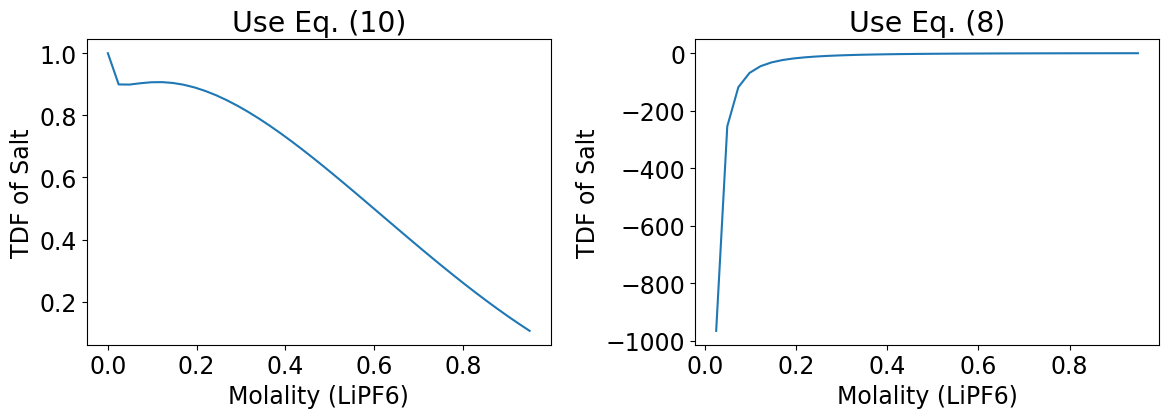

In [6]:
# Plot:
fig, axs = plt.subplots(1,2, figsize=(12,4.5),tight_layout=True)
axs[0].plot(m_e_List,TDF_Salt_List)
axs[1].plot(m_e_List,TDF_Salt_List2)
axs[0].set_title("Use Eq. (10)")
axs[1].set_title("Use Eq. (8)")
for i in range(2):
    axs[i].set_ylabel("TDF of Salt")
    axs[i].set_xlabel("Molality (LiPF6)")